<a href="https://colab.research.google.com/github/KnyazevAV/hangman/blob/master/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%98%D1%81%D0%BA%D1%83%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%98%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0_(%D0%9A%D0%BD%D1%8F%D0%B7%D0%B5%D0%B2_%D0%90_)_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Нейросеть для всех испытуемых c разбивкой на 1 секунду и перемешиванием CNN+LSTM Tahn

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами
import random

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, LSTM, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Reshape, Bidirectional #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback, LearningRateScheduler # подключаем колбэки
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
import tensorflow as tf
from contextlib import suppress


from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
import os
import sys
import matplotlib.pyplot as plt #Отрисовка графиков

from statistics import mean 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/temp/fnirs_dataset'

In [ ]:
#функция загрузки данных в один dataframe
def data_load(path):
  frames_temp = []
  #try:
  for i in range(100):
      with suppress(FileNotFoundError):
        i += 1
        df_temp = pd.read_csv(path + '/sub_{}.csv'.format(i))
        frames_temp.append(df_temp)
  #except FileNotFoundError:
    #print('такого номера нет:', i)
  df_full = pd.concat(frames_temp, axis=0, join='outer', ignore_index=True, keys=None)
  return df_full

In [ ]:
df_full = data_load('/content/drive/My Drive/temp/fnirs_dataset')

In [ ]:
df_full

,AB_I_O,AB_PHI_O,AB_I_DO,AB_PHI_DO,CD_I_O,CD_PHI_O,CD_I_DO,CD_PHI_DO,label
0,-0.198291,0.335677,-0.560790,-0.056042,0.460231,0.271119,-0.645892,0.198804,0
1,-0.195651,0.297210,-0.580712,-0.032170,0.524553,0.208284,-0.681370,0.202136,0
2,-0.192790,0.275041,-0.600446,-0.012370,0.585149,0.162781,-0.716632,0.194758,0
3,-0.189943,0.271573,-0.619751,0.002192,0.641092,0.133816,-0.750998,0.176938,0
4,-0.187401,0.288043,-0.638379,0.010818,0.691434,0.119983,-0.783748,0.149429,0
...,...,...,...,...,...,...,...,...,...
422587,3.369915,0.973203,-1.159197,0.057686,2.524704,45.670449,-1.088880,-60.652208,2
422588,3.365014,1.040236,-1.161509,0.013463,2.514158,43.258719,-1.090080,-57.468358,2
422589,3.358334,1.105486,-1.163388,-0.026700,2.507242,40.041532,-1.091969,-53.234109,2
422590,3.350465,1.165158,-1.165147,-0.061719,2.504038,35.925716,-1.094843,-47.821654,2


In [ ]:
#посмотрим, как выстроена парадигма исследования (как n-back задачи идут друг за другом)
n_back_labels = []
for i in range(len(df_full.label)):
  if i == 0:
    n_back_labels.append(df_full.label[i])
    continue
  if df_full.label[i] == df_full.label[i-1]:
    continue
  else:
    n_back_labels.append(df_full.label[i])

In [ ]:
print('кол-во задач:', len(n_back_labels))
print('кол-во отсчетов на 1 задачу:', len(df_full)/len(n_back_labels))

кол-во задач: 992
кол-во отсчетов на 1 задачу: 426.0


Попробуем сделать разбивку на 6 измерений, что примерно эквивалентно 1 секунде

напишем функцию подготовки xTrain и yTrain

In [ ]:
def drop_dataset(dataset, xLen):

  #соберем данные в список
  l_Train = []

  i = 0
  while i <= len(dataset):
    l_Train.append(dataset[i:i+xLen])
    i += xLen

  #удалим последний "пустой" элемент списка
  l_Train.pop(int(len(dataset)/xLen))  
  
  #перемешаем список l_xTrain
  random.shuffle(l_Train)

  #сформируем xTrain и yTrain
  xTrain_list = []
  yTrain_list = []
  for i in range(len(l_Train)):
    xTrain_list.append(l_Train[i][['AB_I_O', 'AB_PHI_O',	'AB_I_DO',	'AB_PHI_DO',	'CD_I_O',	'CD_PHI_O',	'CD_I_DO',	'CD_PHI_DO']])
    yTrain_list.append(l_Train[i][['label']])


  xTrain = np.array(xTrain_list)

  #доделаем yTrain
  l1 = []
  l2 = []
  l3 = []
  for i in range(len(yTrain_list)):

    #l1.clear()
    l1 = []
    for j in range(len(yTrain_list[i])):

      l1.append(int(yTrain_list[i].iloc[j][0]))
    l2.append(l1)


  #сформируем список длинною xTrain со значениями номеров задач n-back
  for i in range(len(l2)):
    l3.append(mean(l2[i]))

  yTrain = np.array( utils.to_categorical(l3, 4))

  return xTrain, yTrain

In [ ]:
xTrain, yTrain = drop_dataset(df_full, 6)

In [ ]:
xTrain.shape, yTrain.shape

((70432, 6, 8), (70432, 4))

Соберем заранее тестовую выборку

In [ ]:
#загрузим 1 датасет, на котором сеть не обучалась
test_dataset = ('/content/drive/My Drive/temp/fnirs_dataset')
df_test = data_load(test_dataset)
xLen = 6
xTest, yTest = drop_dataset(df_test, xLen)

Напишем LSTM

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
xLen = 6

In [ ]:
inputs = Input((xLen, 8))

x = Conv1D(256, 3, strides=1, padding='same', activation='tanh')(inputs)
x = Conv1D(128, 3, strides=1 ,padding='same', activation='tanh')(x)
x = Conv1D(64, 3, strides=1, padding='same', activation='tanh')(x)
x = Conv1D(32, 3, strides=1, padding='same', activation='tanh')(x)
x = BatchNormalization()(x)
x = MaxPooling1D()(x)

x = LSTM(256, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = LSTM(128)(x)
x = BatchNormalization()(x)
x = tf.expand_dims(x, axis=-1)
x = LSTM(64)(x)
x = BatchNormalization()(x)


x = Dense(256, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)
x = Dense(64, activation='tanh')(x)
x = Dense(32, activation='tanh')(x)
x = Dropout(0.5)(x)

output = Dense(4, activation='softmax')(x)

model_CNN_LSTM = Model(inputs, output)
model_CNN_LSTM.compile(loss=loss_fn, optimizer=Adam(lr=1e-4), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_CNN_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 256)            271360    
                                                                 
 batch_normalization_1 (Batc  (None, 6, 256)           1024      
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 128, 1)           0     

In [ ]:
history_CNN_LSTM = model_CNN_LSTM.fit(xTrain, yTrain, epochs=50, batch_size=64, verbose=1, validation_split=0.1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


991/991 [==============================] - 25s 15ms/step - loss: 1.3588 - accuracy: 0.3209 - val_loss: 1.3403 - val_accuracy: 0.3392
Epoch 2/50
991/991 [==============================] - 13s 13ms/step - loss: 1.3364 - accuracy: 0.3477 - val_loss: 1.3245 - val_accuracy: 0.3582
Epoch 3/50
991/991 [==============================] - 13s 13ms/step - loss: 1.3234 - accuracy: 0.3623 - val_loss: 1.3102 - val_accuracy: 0.3751
Epoch 4/50
991/991 [==============================] - 13s 13ms/step - loss: 1.3107 - accuracy: 0.3739 - val_loss: 1.3007 - val_accuracy: 0.3795
Epoch 5/50
991/991 [==============================] - 13s 13ms/step - loss: 1.3016 - accuracy: 0.3810 - val_loss: 1.2859 - val_accuracy: 0.3903
Epoch 6/50
991/991 [==============================] - 13s 13ms/step - loss: 1.2925 - accuracy: 0.3906 - val_loss: 1.2850 - val_accuracy: 0.3878
Epoch 7/50
991/991 [==============================] - 13s 13ms/step - loss: 1.2819 - accuracy: 0.3977 - val_loss: 1.2765 - val_accuracy: 0.3971
Epo

In [ ]:
model_CNN_LSTM.evaluate(xTest, yTest)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2201/2201 [==============================] - 14s 6ms/step - loss: 1.0193 - accuracy: 0.5519


[1.0193222761154175, 0.5518798232078552]

In [ ]:
history_CNN_LSTM = model_CNN_LSTM.fit(xTrain, yTrain, epochs=150, batch_size=64, verbose=1, validation_split=0.1)

Epoch 1/150
991/991 [==============================] - 13s 13ms/step - loss: 1.0783 - accuracy: 0.5229 - val_loss: 1.1784 - val_accuracy: 0.4611
Epoch 2/150
991/991 [==============================] - 13s 13ms/step - loss: 1.0775 - accuracy: 0.5224 - val_loss: 1.1443 - val_accuracy: 0.4827
Epoch 3/150
991/991 [==============================] - 14s 14ms/step - loss: 1.0720 - accuracy: 0.5257 - val_loss: 1.1378 - val_accuracy: 0.4851
Epoch 4/150
991/991 [==============================] - 13s 13ms/step - loss: 1.0702 - accuracy: 0.5282 - val_loss: 1.1973 - val_accuracy: 0.4629
Epoch 5/150
991/991 [==============================] - 13s 13ms/step - loss: 1.0657 - accuracy: 0.5288 - val_loss: 1.1546 - val_accuracy: 0.4788
Epoch 6/150
991/991 [==============================] - 13s 13ms/step - loss: 1.0606 - accuracy: 0.5331 - val_loss: 1.1423 - val_accuracy: 0.4813
Epoch 7/150
991/991 [==============================] - 13s 13ms/step - loss: 1.0587 - accuracy: 0.5319 - val_loss: 1.1574 - val_ac

In [ ]:
model_CNN_LSTM.evaluate(xTest, yTest)

2201/2201 [==============================] - 13s 6ms/step - loss: 0.5842 - accuracy: 0.7690


[0.5841527581214905, 0.7689686417579651]

In [ ]:
history_CNN_LSTM = model_CNN_LSTM.fit(xTrain, yTrain, epochs=150, batch_size=128, verbose=1, validation_split=0.1)

Epoch 1/150
496/496 [==============================] - 7s 15ms/step - loss: 0.5333 - accuracy: 0.7839 - val_loss: 1.3866 - val_accuracy: 0.5442
Epoch 2/150
496/496 [==============================] - 7s 14ms/step - loss: 0.5306 - accuracy: 0.7840 - val_loss: 1.3849 - val_accuracy: 0.5468
Epoch 3/150
496/496 [==============================] - 7s 14ms/step - loss: 0.5265 - accuracy: 0.7877 - val_loss: 1.4474 - val_accuracy: 0.5464
Epoch 4/150
496/496 [==============================] - 7s 14ms/step - loss: 0.5244 - accuracy: 0.7875 - val_loss: 1.4394 - val_accuracy: 0.5450
Epoch 5/150
496/496 [==============================] - 7s 14ms/step - loss: 0.5220 - accuracy: 0.7878 - val_loss: 1.4234 - val_accuracy: 0.5484
Epoch 6/150
496/496 [==============================] - 7s 14ms/step - loss: 0.5198 - accuracy: 0.7903 - val_loss: 1.4066 - val_accuracy: 0.5480
Epoch 7/150
496/496 [==============================] - 7s 14ms/step - loss: 0.5177 - accuracy: 0.7910 - val_loss: 1.3992 - val_accuracy:

In [ ]:
model_CNN_LSTM.evaluate(xTest, yTest)

2201/2201 [==============================] - 13s 6ms/step - loss: 0.3593 - accuracy: 0.9017


[0.35933899879455566, 0.9016640186309814]

In [ ]:
stop

In [ ]:
from keras.models import load_model



In [ ]:
model_CNN_LSTM.save('/content/drive/My Drive/temp/model_CNN_LSTM_tanh_final.h5')

In [ ]:
model_CNN_LSTM = load_model('/content/drive/My Drive/temp/model_CNN_LSTM_tanh_final.h5')

In [ ]:
#загрузим 1 датасет, на котором сеть не обучалась
sub1_97_file = '/content/drive/My Drive/temp/fnirs_dataset test/sub_97.csv'
df_test = pd.read_csv(sub1_97_file)
xLen = 6
xTest97, yTest97 = drop_dataset(df_test, xLen)

In [ ]:
model_CNN_LSTM.evaluate(xTest97, yTest97)

36/36 [==============================] - 0s 8ms/step - loss: 4.1268 - accuracy: 0.2324


[4.1267876625061035, 0.23239436745643616]

In [ ]:
xTest97.shape, yTest97.shape

Попробуем дообучить модель на 97ом испытуемом
Для этого разобьем датасет на обучающую и тестовую выборку

In [ ]:
xTest97[0].shape

In [ ]:
xTrain97 = xTest97[0:int(len(xTest97)*0.9)]
xVal97 = xTest97[int(len(xTest97)*0.9 + 1):]

yTrain97 = yTest97[0:int(len(yTest97)*0.9)]
yVal97 = yTest97[int(len(yTest97)*0.9 + 1):]

xTrain97.shape, xVal97.shape, yTrain97.shape, yVal97.shape, len(xTest97)

((1022, 6, 8), (113, 6, 8), (1022, 4), (113, 4), 1136)

In [ ]:
history97 = model_CNN_LSTM.fit(xTrain97, yTrain97, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
16/16 [==============================] - 0s 16ms/step - loss: 2.8244 - accuracy: 0.3659
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.0626 - accuracy: 0.5626
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.7774 - accuracy: 0.6712
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6566 - accuracy: 0.7329
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.5972 - accuracy: 0.7554
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 0.5216 - accuracy: 0.7769
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 0.4830 - accuracy: 0.8102
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 0.4246 - accuracy: 0.8190
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 0.3803 - accuracy: 0.8474
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 0.3418 - accuracy: 0.8728
Epoch 11/

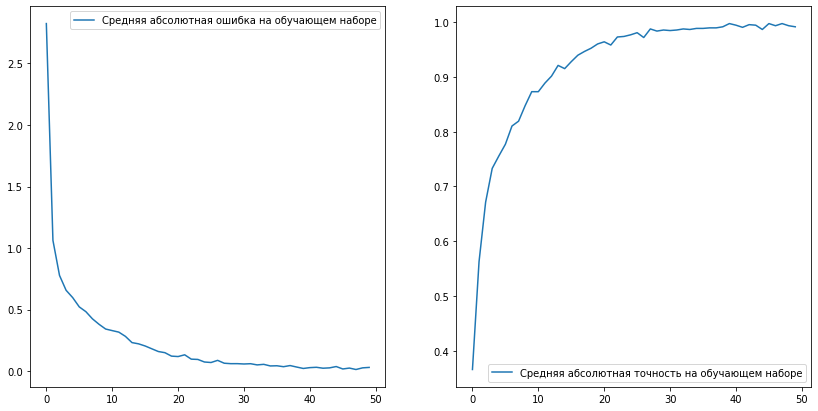

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14, 7))
axs[0].plot(history97.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
axs[0].legend()

axs[1].plot(history97.history['accuracy'], 
         label='Средняя абсолютная точность на обучающем наборе')
axs[1].legend()
plt.show()

In [ ]:
model_CNN_LSTM.evaluate(xVal97, yVal97)

4/4 [==============================] - 0s 8ms/step - loss: 0.2614 - accuracy: 0.9381


[0.26138007640838623, 0.9380530714988708]